In [1]:
# Import standard libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import math
from collections import defaultdict
import tqdm
import warnings
warnings.filterwarnings('ignore')

# Import for text analytics
import spacy
from spacy import displacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
import string
import gensim
from gensim.models import Word2Vec
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim.models import LdaModel, CoherenceModel, TfidfModel
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess
from gensim import corpora
import torch
import torch.nn as nn
from torch.optim import Adam
from transformers import CamembertTokenizer, CamembertModel
from transformers import AutoModel, AutoTokenizer
from transformers import BertTokenizer, BertModel
from transformers import FlaubertModel, FlaubertTokenizer
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas

# Import for classification
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix # Confusion matrix
import joblib
device = torch.device('mps')

# Import for youtube data extraction and display
from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from youtube_transcript_api import YouTubeTranscriptApi
from IPython.display import Image, display, HTML
import re
import os
import pickle

# Import for social network analysis
import networkx as nx

# Data Preperation and Exploration

## Data Augmentation and Cleaning

As we have found some data from the other sources (https://github.com/loicrouillermonay/BSA2021), we would like to augment our original dataset with the new sources. After the augmentation, we have to clean the data (namely drop duplicates).

In [2]:
train_ori = pd.read_csv('training_data.csv').drop(columns=['id'])
test = pd.read_csv('unlabelled_test_data.csv').drop(columns=['id'])

In [3]:
train_other = pd.read_csv('max-dataset.csv').rename(columns={'Text':'sentence', 'Difficulty':'difficulty'})
train_other

,sentence,difficulty
0,Je recherche une personne pour garder mes enfa...,A1
1,Il faut être disponible pour travailler les je...,A1
2,Vous devez habiter dans le centre de Limoges o...,A1
3,Expérience avec les enfants souhaitée.,A1
4,"Si vous êtes intéressé, appelez-moi.",A1
...,...,...
9169,"La vieille acquiesça de la tête, sous sa grand...",C2
9170,Il fallait qu’il débitât les nouvelles apprise...,C2
9171,"Vous eussiez dit deux éclairs bleuâtres, parei...",C2
9172,Elle dénoua le ruban qui attachait le manche d...,C2


In [4]:
display(train_ori)
display(test)

,sentence,difficulty
0,Les coûts kilométriques réels peuvent diverger...,C1
1,"Le bleu, c'est ma couleur préférée mais je n'a...",A1
2,Le test de niveau en français est sur le site ...,A1
3,Est-ce que ton mari est aussi de Boston?,A1
4,"Dans les écoles de commerce, dans les couloirs...",B1
...,...,...
4795,"C'est pourquoi, il décida de remplacer les hab...",B2
4796,Il avait une de ces pâleurs splendides qui don...,C1
4797,"Et le premier samedi de chaque mois, venez ren...",A2
4798,Les coûts liés à la journalisation n'étant pas...,C2


,sentence
0,Nous dûmes nous excuser des propos que nous eû...
1,Vous ne pouvez pas savoir le plaisir que j'ai ...
2,"Et, paradoxalement, boire froid n'est pas la b..."
3,"Ce n'est pas étonnant, car c'est une saison my..."
4,"Le corps de Golo lui-même, d'une essence aussi..."
...,...
1195,C'est un phénomène qui trouve une accélération...
1196,Je vais parler au serveur et voir si on peut d...
1197,Il n'était pas comme tant de gens qui par pare...
1198,Ils deviennent dangereux pour notre économie.


In [5]:
train = pd.concat([train_other, train_ori])
train = train.drop_duplicates()
train = train.sample(frac=1, random_state=42).reset_index(drop=True)
train

,sentence,difficulty
0,La moto devint une marque distinctive de liber...,B2
1,Il est employé,A1
2,Je suis bien arrivé à Londres.,A2
3,La cinquantaine marque une rupture dans la vie...,C1
4,Elle parle anglais et français et elle étudie ...,A1
...,...,...
10866,Au moins sept manifestants pro-démocratie ont ...,C1
10867,"Je vais être en retard ce soir, peux-tu prépar...",B2
10868,Ma famille se compose de quatre personnes,A1
10869,"Depuis qu’elles se sont diversifiées, au moins...",C1


## Exploratory Data Analysis

In [6]:
# Create a new column to store the length of the texts
train['sentence length'] = train['sentence'].apply(lambda x: len(str(x)))
train

,sentence,difficulty,sentence length
0,La moto devint une marque distinctive de liber...,B2,82
1,Il est employé,A1,14
2,Je suis bien arrivé à Londres.,A2,30
3,La cinquantaine marque une rupture dans la vie...,C1,145
4,Elle parle anglais et français et elle étudie ...,A1,56
...,...,...,...
10866,Au moins sept manifestants pro-démocratie ont ...,C1,274
10867,"Je vais être en retard ce soir, peux-tu prépar...",B2,71
10868,Ma famille se compose de quatre personnes,A1,41
10869,"Depuis qu’elles se sont diversifiées, au moins...",C1,115


In [7]:
train_mean_length = train.groupby(['difficulty']).mean().reset_index().rename(columns={'sentence length': 'mean length'})
train_count = train.groupby(['difficulty']).count().reset_index().drop(columns=['sentence']).rename(columns={'sentence length': 'count'})
train_eda = train_mean_length.merge(train_count, on='difficulty')
train_eda

,difficulty,mean length,count
0,A1,42.898670,1579
1,A2,64.973542,2041
2,B1,88.757473,1773
3,B2,116.749716,1758
4,C1,147.102167,1938
5,C2,201.145342,1782


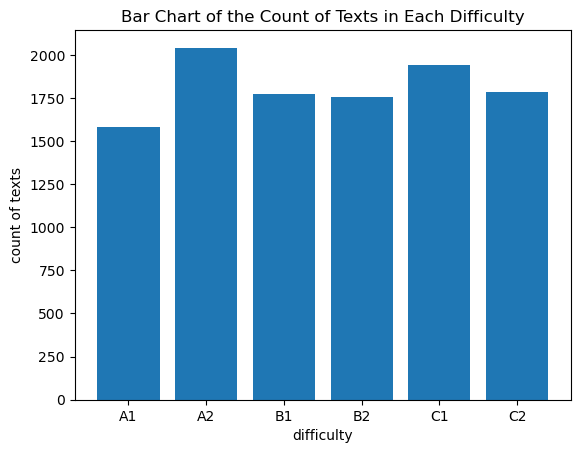

In [8]:
# Draw the bar chart of the count of texts in each difficulty
plt.bar(train_eda['difficulty'], train_eda['count'])
plt.title('Bar Chart of the Count of Texts in Each Difficulty')
plt.xlabel('difficulty')
plt.ylabel('count of texts')

plt.show()

Each label has a relatively evenly distributed amount of text.

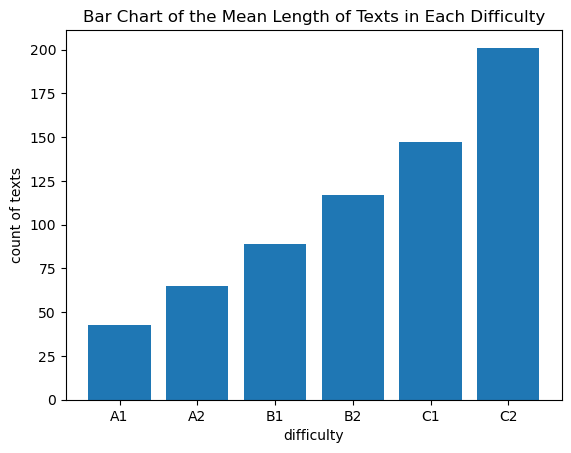

In [9]:
# Draw the bar chart of the mean length of texts in each difficulty
plt.bar(train_eda['difficulty'], train_eda['mean length'])

plt.title('Bar Chart of the Mean Length of Texts in Each Difficulty')
plt.xlabel('difficulty')
plt.ylabel('count of texts')

plt.show()

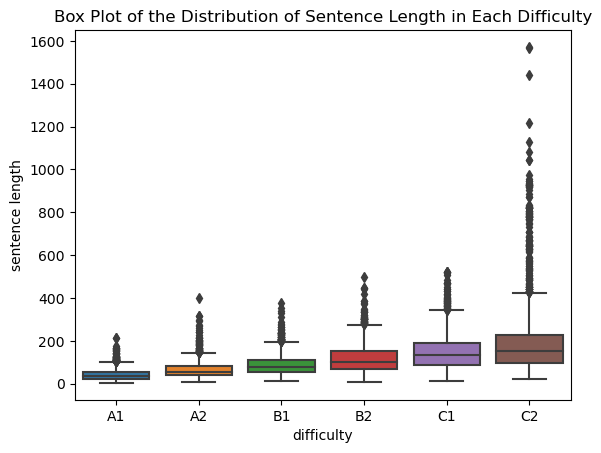

In [10]:
# Draw the box plot
sns.boxplot(x='difficulty', y='sentence length', data=train, order=['A1', 'A2', 'B1', 'B2', 'C1', 'C2'])

plt.title("Box Plot of the Distribution of Sentence Length in Each Difficulty")
plt.xlabel("difficulty")
plt.ylabel("sentence length")

plt.show()

It's noteworthy that the more length they have, the more difficulty the texts will be labeled as generally. However, as we haven't done any processing to the texts (e.g. tokenization), the texts are likely to be longer than the tokenized ones.

In [11]:
# Create X and y for the model training
X = train['sentence']
y = train['difficulty']

# PART 1: Text Difficulty Classification

## Bert: Tokenization and Text Feature Extraction

In [12]:
# Cambert model
tokenizer = CamembertTokenizer.from_pretrained('camembert-base')
model = CamembertModel.from_pretrained('camembert-base', num_labels=6).to(device)

# Flaubert model
# tokenizer = FlaubertTokenizer.from_pretrained('flaubert/flaubert_base_cased')
# model = FlaubertModel.from_pretrained('flaubert/flaubert_base_cased', num_labels=6).to(device)

# Multilingual model
# tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
# model = BertModel.from_pretrained('bert-base-multilingual-cased', num_labels=6).to(device)

def bert_feature(data, **kwargs):
    # Tokenize and encode input texts
    input_ids = [tokenizer.encode(text, add_special_tokens=True, **kwargs) for text in data]

    # Extract BERT features for each input ID
    features = []
    with torch.no_grad():
        for input_id in tqdm.tqdm(input_ids):
            # Convert input ID to tensor
            input_tensor = torch.tensor(input_id).unsqueeze(0).to(device)

            # Extract BERT features for this input ID
            input_embeds = model.embeddings(input_tensor)
            feature = model(inputs_embeds=input_embeds)[0][:, 0, :].cpu().numpy()

            # Add feature to list of all features
            features.append(feature)

    # Concatenate features from all inputs
    feature_data = np.concatenate(features, axis=0)

    torch.cuda.empty_cache()

    return feature_data

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertModel: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing CamembertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [13]:
X = bert_feature(X)

100%|██████████| 10871/10871 [04:21<00:00, 41.63it/s]


In [14]:
# Display the outcome after the feature extraction
pd.DataFrame(X)

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.009658,0.204015,0.066226,-0.054740,0.067690,-0.099764,-0.021509,0.194520,0.083554,0.073023,...,-0.104704,-0.057351,-0.293228,0.125889,0.064608,0.002787,0.039208,-0.065193,0.047916,-0.057475
1,0.004873,0.094215,0.107688,-0.127375,-0.078371,0.006411,0.002898,0.211890,0.009665,0.030050,...,-0.085537,0.011440,-0.165532,0.098862,0.001680,0.083010,0.089971,-0.056787,-0.043223,-0.128083
2,-0.008067,0.076027,0.129097,-0.065913,-0.002792,0.087863,0.027575,0.231411,-0.040903,0.120860,...,-0.055490,-0.022552,-0.150907,0.123795,0.048560,0.064020,0.111041,-0.050249,0.018296,-0.031134
3,-0.034347,0.094695,-0.041662,-0.050721,-0.119591,-0.073223,0.006999,0.249484,0.016757,0.070269,...,-0.017139,-0.129802,-0.122004,0.101529,-0.017249,0.069578,0.027919,-0.036510,0.066400,-0.072212
4,-0.019092,0.073252,0.108718,-0.125545,-0.039069,-0.008434,-0.015010,0.263034,0.008885,0.177239,...,-0.018939,0.004761,-0.151420,0.108461,0.123690,0.075781,0.022834,-0.067982,-0.021448,-0.031718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10866,0.015122,0.166713,0.114754,-0.093979,-0.022310,0.025477,-0.067050,0.258021,-0.032255,0.124273,...,-0.013918,-0.155387,-0.185953,0.120019,0.030759,-0.015543,0.013821,-0.131124,0.024897,-0.001090
10867,-0.029814,0.061035,0.143973,-0.036999,-0.041944,0.049765,0.017360,0.308143,0.033817,0.150243,...,-0.044106,-0.008457,-0.094575,0.120175,0.000506,0.070414,0.038460,-0.127833,0.067543,0.035968
10868,0.015691,0.118440,0.052074,-0.126597,-0.016131,-0.075390,0.001682,0.339817,-0.026803,0.111593,...,-0.102620,0.034236,-0.155104,0.036178,0.054890,0.079816,-0.002565,-0.077096,-0.084497,-0.084767
10869,-0.047853,0.116696,0.088597,-0.042536,-0.072561,-0.040958,0.013786,0.271830,-0.019715,0.075964,...,-0.025039,-0.120551,-0.141868,0.123347,0.052299,0.167325,-0.002249,0.039464,0.025091,-0.018311


## Compare Classification Models

In [15]:
def evaluation(model, X_test, y_test):
    y_pred = model.predict(X_test)
    model_accuracy = accuracy_score(y_test, y_pred)
    model_precision = precision_score(y_test, y_pred, average='macro')
    model_recall = recall_score(y_test, y_pred, average='macro')
    model_f1 = f1_score(y_test, y_pred, average='macro')
    model_eval = [model_accuracy, model_precision, model_recall, model_f1]
    return model_eval

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [17]:
# Define the encoder
le = LabelEncoder()
# Fit the encoder
le.fit(y_train)

y_train = le.transform(y_train)
y_test = le.transform(y_test)

In [18]:
model_comparison = pd.DataFrame(index=['Accuracy', 'Precision', 'Recall', 'F1'])

In [19]:
svc_model = SVC(C=1, kernel='rbf', gamma='scale')
svc_model.fit(X_train, y_train)

model_comparison['SVC'] = evaluation(svc_model, X_test, y_test)
model_comparison

,SVC
Accuracy,0.506434
Precision,0.514941
Recall,0.504060
F1,0.505178


In [20]:
knn_model = KNeighborsClassifier(algorithm="kd_tree")
knn_model.fit(X_train,y_train)

model_comparison['KNN'] = evaluation(knn_model, X_test, y_test)
model_comparison

,SVC,KNN
Accuracy,0.506434,0.536765
Precision,0.514941,0.553980
Recall,0.504060,0.538852
F1,0.505178,0.537776


In [21]:
logi_model = LogisticRegression()
logi_model.fit(X_train,y_train)

model_comparison['Logistic Regression'] = evaluation(logi_model, X_test, y_test)
model_comparison

,SVC,KNN,Logistic Regression
Accuracy,0.506434,0.536765,0.542279
Precision,0.514941,0.553980,0.543911
Recall,0.504060,0.538852,0.544995
F1,0.505178,0.537776,0.543103


In [22]:
rfc_model = RandomForestClassifier(random_state=42)
rfc_model.fit(X_train,y_train)

model_comparison['Random Forest'] = evaluation(rfc_model, X_test, y_test)
model_comparison

,SVC,KNN,Logistic Regression,Random Forest
Accuracy,0.506434,0.536765,0.542279,0.579044
Precision,0.514941,0.553980,0.543911,0.589596
Recall,0.504060,0.538852,0.544995,0.578662
F1,0.505178,0.537776,0.543103,0.581227


AS **Random Forest Classifier** shows the absolutely best performance in terms of all 4 metrics here, we seek to apply the GridSearch method for the optimization. We use some different parameters below but it would take long to run the method.

For futher classifiers (i.e. ExtraTrees, LightGBM, XGBoost), we also try GridSearch method for them, yet each of them will take a long time. For the sake of time, we will only display the results of the three classifiers with the default and best parameters.

In [23]:
# rfc_parameters = {
#     'n_estimators': [100, 200, 300], 
#     'max_depth': [None, 5, 10], 
#     'min_samples_split': [2, 4, 6],
#     'randon_state': [42]
# }

# grid_etc = GridSearchCV(estimator=RandomForestClassifier(), param_grid=rfc_parameters, cv=7, scoring='accuracy')

# grid_etc.fit(X_train, y_train)

# print("Best Parameters: ", grid_etc.best_params_)
# print("Best Score: ", grid_etc.best_score_)

In [24]:
rfc_model_best = RandomForestClassifier(max_depth=None, min_samples_split=2, n_estimators=300, random_state=42)
rfc_model_best.fit(X_train,y_train)

model_comparison['Random Forest (best para)'] = evaluation(rfc_model_best, X_test, y_test)
model_comparison

,SVC,KNN,Logistic Regression,Random Forest,Random Forest (best para)
Accuracy,0.506434,0.536765,0.542279,0.579044,0.611213
Precision,0.514941,0.553980,0.543911,0.589596,0.626067
Recall,0.504060,0.538852,0.544995,0.578662,0.610947
F1,0.505178,0.537776,0.543103,0.581227,0.614183


In [25]:
etc_model = ExtraTreesClassifier(random_state=42)
etc_model.fit(X_train,y_train)

model_comparison['Extra Trees'] = evaluation(etc_model, X_test, y_test)
model_comparison

,SVC,KNN,Logistic Regression,Random Forest,Random Forest (best para),Extra Trees
Accuracy,0.506434,0.536765,0.542279,0.579044,0.611213,0.608456
Precision,0.514941,0.553980,0.543911,0.589596,0.626067,0.621664
Recall,0.504060,0.538852,0.544995,0.578662,0.610947,0.609443
F1,0.505178,0.537776,0.543103,0.581227,0.614183,0.613173


In [26]:
# etc_parameters = {
#     'n_estimators': [100, 200, 300],  
#     'min_samples_split': [2, 5, 10], 
#     'min_samples_leaf': [1, 2, 4],
#     'randon_state': [42]
# }

# grid_etc = GridSearchCV(estimator=ExtraTreesClassifier(), param_grid=etc_parameters, cv=7, scoring='accuracy')

# grid_etc.fit(X_train, y_train)

# print("Best Parameters: ", grid_etc.best_params_)
# print("Best Score: ", grid_etc.best_score_)

In [27]:
etc_model_best = ExtraTreesClassifier(min_samples_leaf=1, min_samples_split=2, n_estimators=300, random_state=42)
etc_model_best.fit(X_train,y_train)

model_comparison['Extra Trees (best para)'] = evaluation(etc_model_best, X_test, y_test)
model_comparison

,SVC,KNN,Logistic Regression,Random Forest,Random Forest (best para),Extra Trees,Extra Trees (best para)
Accuracy,0.506434,0.536765,0.542279,0.579044,0.611213,0.608456,0.624081
Precision,0.514941,0.553980,0.543911,0.589596,0.626067,0.621664,0.636840
Recall,0.504060,0.538852,0.544995,0.578662,0.610947,0.609443,0.623988
F1,0.505178,0.537776,0.543103,0.581227,0.614183,0.613173,0.627376


In [28]:
lgb_model = LGBMClassifier()
lgb_model.fit(X_train,y_train)

model_comparison['LightGBM'] = evaluation(lgb_model, X_test, y_test)
model_comparison

,SVC,KNN,Logistic Regression,Random Forest,Random Forest (best para),Extra Trees,Extra Trees (best para),LightGBM
Accuracy,0.506434,0.536765,0.542279,0.579044,0.611213,0.608456,0.624081,0.606618
Precision,0.514941,0.553980,0.543911,0.589596,0.626067,0.621664,0.636840,0.618743
Recall,0.504060,0.538852,0.544995,0.578662,0.610947,0.609443,0.623988,0.607830
F1,0.505178,0.537776,0.543103,0.581227,0.614183,0.613173,0.627376,0.611910


In [29]:
# lgb_parameters = {
#     'max_depth': [-1,3,5,7,9],
#     'learning_rate': [0.01,0.05,0.1,0.2]
# }

# grid_lgb = GridSearchCV(estimator = LGBMClassifier(), param_grid = lgb_parameters, cv=7, scoring='accuracy')

# grid_lgb.fit(X_train,y_train)

# print("Best Parameters: ", grid_lgb.best_params_)
# print("Best Score: ", grid_lgb.best_score_)

In [30]:
lgb_model_best = LGBMClassifier(learning_rate=0.2, max_depth=7)
lgb_model_best.fit(X_train,y_train)

model_comparison['LightGBM (best para)'] = evaluation(lgb_model_best, X_test, y_test)
model_comparison

,SVC,KNN,Logistic Regression,Random Forest,Random Forest (best para),Extra Trees,Extra Trees (best para),LightGBM,LightGBM (best para)
Accuracy,0.506434,0.536765,0.542279,0.579044,0.611213,0.608456,0.624081,0.606618,0.617647
Precision,0.514941,0.553980,0.543911,0.589596,0.626067,0.621664,0.636840,0.618743,0.628955
Recall,0.504060,0.538852,0.544995,0.578662,0.610947,0.609443,0.623988,0.607830,0.618681
F1,0.505178,0.537776,0.543103,0.581227,0.614183,0.613173,0.627376,0.611910,0.622191


In [31]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train,y_train)

model_comparison['XGBoost'] = evaluation(xgb_model, X_test, y_test)
model_comparison

,SVC,KNN,Logistic Regression,Random Forest,Random Forest (best para),Extra Trees,Extra Trees (best para),LightGBM,LightGBM (best para),XGBoost
Accuracy,0.506434,0.536765,0.542279,0.579044,0.611213,0.608456,0.624081,0.606618,0.617647,0.613051
Precision,0.514941,0.553980,0.543911,0.589596,0.626067,0.621664,0.636840,0.618743,0.628955,0.623097
Recall,0.504060,0.538852,0.544995,0.578662,0.610947,0.609443,0.623988,0.607830,0.618681,0.614737
F1,0.505178,0.537776,0.543103,0.581227,0.614183,0.613173,0.627376,0.611910,0.622191,0.617457


In [32]:
# xgb_parameters = {
#     'max_depth': [3,5,7,9],
#     'learning_rate': [0.1,0.2]
# }
# grid_xgb = GridSearchCV(estimator = XGBClassifier(), param_grid = xgb_parameters, cv=7, scoring='accuracy')

# grid_xgb.fit(X_train,y_train)

# print("Best Parameters: ", grid_xgb.best_params_)
# print("Best Score: ", grid_xgb.best_score_)

In [33]:
xgb_model_best = XGBClassifier(learning_rate=0.2, max_depth=9)
xgb_model_best.fit(X_train,y_train)

model_comparison['XGBoost (best para)'] = evaluation(xgb_model_best, X_test, y_test)
model_comparison

,SVC,KNN,Logistic Regression,Random Forest,Random Forest (best para),Extra Trees,Extra Trees (best para),LightGBM,LightGBM (best para),XGBoost,XGBoost (best para)
Accuracy,0.506434,0.536765,0.542279,0.579044,0.611213,0.608456,0.624081,0.606618,0.617647,0.613051,0.609375
Precision,0.514941,0.553980,0.543911,0.589596,0.626067,0.621664,0.636840,0.618743,0.628955,0.623097,0.613764
Recall,0.504060,0.538852,0.544995,0.578662,0.610947,0.609443,0.623988,0.607830,0.618681,0.614737,0.611237
F1,0.505178,0.537776,0.543103,0.581227,0.614183,0.613173,0.627376,0.611910,0.622191,0.617457,0.612133


In [34]:
cb_model_bert = CatBoostClassifier()
cb_model_bert.fit(X_train,y_train)

model_comparison['Catboost'] = evaluation(cb_model_bert, X_test, y_test)
model_comparison

Learning rate set to 0.088887
0:	learn: 1.7455598	total: 606ms	remaining: 10m 5s
1:	learn: 1.7113776	total: 893ms	remaining: 7m 25s
2:	learn: 1.6773483	total: 1.16s	remaining: 6m 25s
3:	learn: 1.6472340	total: 1.48s	remaining: 6m 7s
4:	learn: 1.6207702	total: 1.78s	remaining: 5m 54s
5:	learn: 1.5937862	total: 2.1s	remaining: 5m 48s
6:	learn: 1.5751678	total: 2.4s	remaining: 5m 39s
7:	learn: 1.5529510	total: 2.89s	remaining: 5m 58s
8:	learn: 1.5356780	total: 3.18s	remaining: 5m 50s
9:	learn: 1.5212232	total: 3.47s	remaining: 5m 43s
10:	learn: 1.5060605	total: 3.77s	remaining: 5m 38s
11:	learn: 1.4925503	total: 4.06s	remaining: 5m 34s
12:	learn: 1.4769174	total: 4.38s	remaining: 5m 32s
13:	learn: 1.4646332	total: 4.67s	remaining: 5m 29s
14:	learn: 1.4532399	total: 5.07s	remaining: 5m 32s
15:	learn: 1.4415238	total: 5.38s	remaining: 5m 31s
16:	learn: 1.4306276	total: 5.7s	remaining: 5m 29s
17:	learn: 1.4210644	total: 6.13s	remaining: 5m 34s
18:	learn: 1.4121770	total: 6.43s	remaining: 5m 

,SVC,KNN,Logistic Regression,Random Forest,Random Forest (best para),Extra Trees,Extra Trees (best para),LightGBM,LightGBM (best para),XGBoost,XGBoost (best para),Catboost
Accuracy,0.506434,0.536765,0.542279,0.579044,0.611213,0.608456,0.624081,0.606618,0.617647,0.613051,0.609375,0.618566
Precision,0.514941,0.553980,0.543911,0.589596,0.626067,0.621664,0.636840,0.618743,0.628955,0.623097,0.613764,0.626426
Recall,0.504060,0.538852,0.544995,0.578662,0.610947,0.609443,0.623988,0.607830,0.618681,0.614737,0.611237,0.619721
F1,0.505178,0.537776,0.543103,0.581227,0.614183,0.613173,0.627376,0.611910,0.622191,0.617457,0.612133,0.622355


In [35]:
# cb_model_ori = CatBoostClassifier()
# xgb_model_ori = XGBClassifier()
# lgb_model_ori = LGBMClassifier()

# voting_classifier = VotingClassifier(estimators=[('cb', cb_model_ori), ('xgb', xgb_model_ori), ('lgb', lgb_model_ori)], voting='hard')
# voting_classifier.fit(X_train, y_train)
# model_comparison_bert['Voting'] = evaluation(voting_classifier, X_test, y_test)
# model_comparison_bert

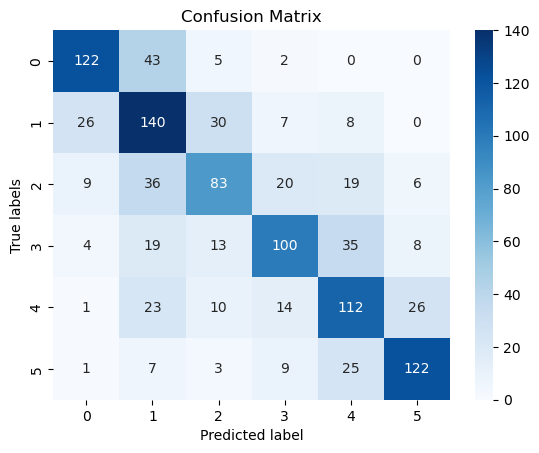

In [36]:
# Draw the confusion matrix
sns.heatmap(confusion_matrix(y_test, etc_model_best.predict(X_test)), annot=True, cmap='Blues', fmt='.4g')
plt.xlabel('Predicted label')

plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [37]:
# Print precision, recall, F1 score for each label
report = classification_report(y_test, etc_model_best.predict(X_test))
print(report)

              precision    recall  f1-score   support

           0       0.75      0.71      0.73       172
           1       0.52      0.66      0.58       211
           2       0.58      0.48      0.52       173
           3       0.66      0.56      0.60       179
           4       0.56      0.60      0.58       186
           5       0.75      0.73      0.74       167

    accuracy                           0.62      1088
   macro avg       0.64      0.62      0.63      1088
weighted avg       0.63      0.62      0.62      1088



In [38]:
# Use sanity checks
etc_model_best.predict(bert_feature([['Je suis Jean'],['Je suis Michalis']]))

100%|██████████| 2/2 [00:01<00:00,  1.64it/s]


array([0, 0])

Both of the texts are categorized as 0 (A1 difficulty), which may indicate the classifier is reasonable. After the sanity checks, we can store our trained model into local repository.

In [39]:
# Store the model
joblib.dump(etc_model_best, 'best_model.pkl')

['best_model.pkl']

## Predict on the Test Set

In [40]:
# Extract text features from test set
test_features = bert_feature(test['sentence'])

100%|██████████| 1200/1200 [00:38<00:00, 31.02it/s]


In [41]:
preds = etc_model_best.predict(test_features)

final_DF = pd.DataFrame()
get_ID = pd.read_csv('unlabelled_test_data.csv')
final_DF['id'] = get_ID['id']
final_DF['difficulty'] = pd.Series(preds).map({0:'A1', 1:'A2', 2:'B1', 3:'B2', 4:'C1', 5:'C2'})

Name = 'outcome.csv'
final_DF.to_csv(Name, index=0)

# PART 2: Text Topic Clustering

## Spacy: Tokenization

In [42]:
# Load French language model
sp = spacy.load("fr_core_news_sm")
sp.Defaults.stop_words |= spacy.lang.fr.stop_words.STOP_WORDS

In [43]:
# Create tokenizer function for preprocessing
def spacy_tokenizer(text):

    # Define stopwords, punctuation, and numbers
    stop_words = spacy.lang.fr.stop_words.STOP_WORDS
    punctuations = string.punctuation +'–' + '—'
    numbers = "0123456789"

    # Create spacy object
    mytokens = sp(text)

    # Lemmatize each token and convert each token into lowercase
    mytokens = ([word.lemma_.lower().strip() for word in mytokens])

    # Remove stop words and punctuation
    mytokens = ([word for word in mytokens 
                 if word not in stop_words and word not in punctuations])

    # Remove sufix like ".[1" in "experience.[1"
    mytokens_2 = []
    for word in mytokens:
        for char in word:
            if (char in punctuations) or (char in numbers):
                word = word.replace(char, "")
        if word != "":
            mytokens_2.append(word)

    # Return preprocessed list of tokens
    return mytokens_2

In [ ]:
# Tokenize texts
texts_tokenized = [spacy_tokenizer(text) for text in train['sentence']]

In [55]:
train['tokenized_sentence_spacy'] = pd.Series(texts_tokenized)
train

,sentence,difficulty,sentence length,tokenized_sentence_spacy
0,La moto devint une marque distinctive de liber...,B2,82,"[moto, devenir, marque, distinctif, liberté, q..."
1,Il est employé,A1,14,[employer]
2,Je suis bien arrivé à Londres.,A2,30,"[bien, arriver, londres]"
3,La cinquantaine marque une rupture dans la vie...,C1,145,"[marque, rupture, vie, femme, synonyme, transf..."
4,Elle parle anglais et français et elle étudie ...,A1,56,"[anglais, français, étudier, espagnol]"
...,...,...,...,...
10866,Au moins sept manifestants pro-démocratie ont ...,C1,274,"[manifestant, prodémocratie, tuer, blessé, mer..."
10867,"Je vais être en retard ce soir, peux-tu prépar...",B2,71,"[aller, retard, soir, préparer, dîner, enfant]"
10868,Ma famille se compose de quatre personnes,A1,41,"[famille, composer]"
10869,"Depuis qu’elles se sont diversifiées, au moins...",C1,115,"[diversifier, naître, éteint, trace]"


## Implement LDA Model

In [45]:
def lda_model_values(num_topics, corpus, dictionary):
    x = [] # x axis
    perplexity_values = [] # Perplexity
    coherence_values = []   # Coherence
    model_list = [] # Store the LDA model of corresponding number of topics

    for topic in tqdm.tqdm(range(num_topics)):
        lda_model = LdaModel(corpus=corpus, num_topics=topic+1, id2word=dictionary, chunksize=2000, passes=20, iterations=400,random_state=1)
        model_list.append(lda_model)
        x.append(topic+1)
        perplexity_values.append(lda_model.log_perplexity(corpus))

        coherencemodel = CoherenceModel(model=lda_model, texts=texts_tokenized, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, x, perplexity_values, coherence_values

100%|██████████| 20/20 [05:29<00:00, 16.47s/it]


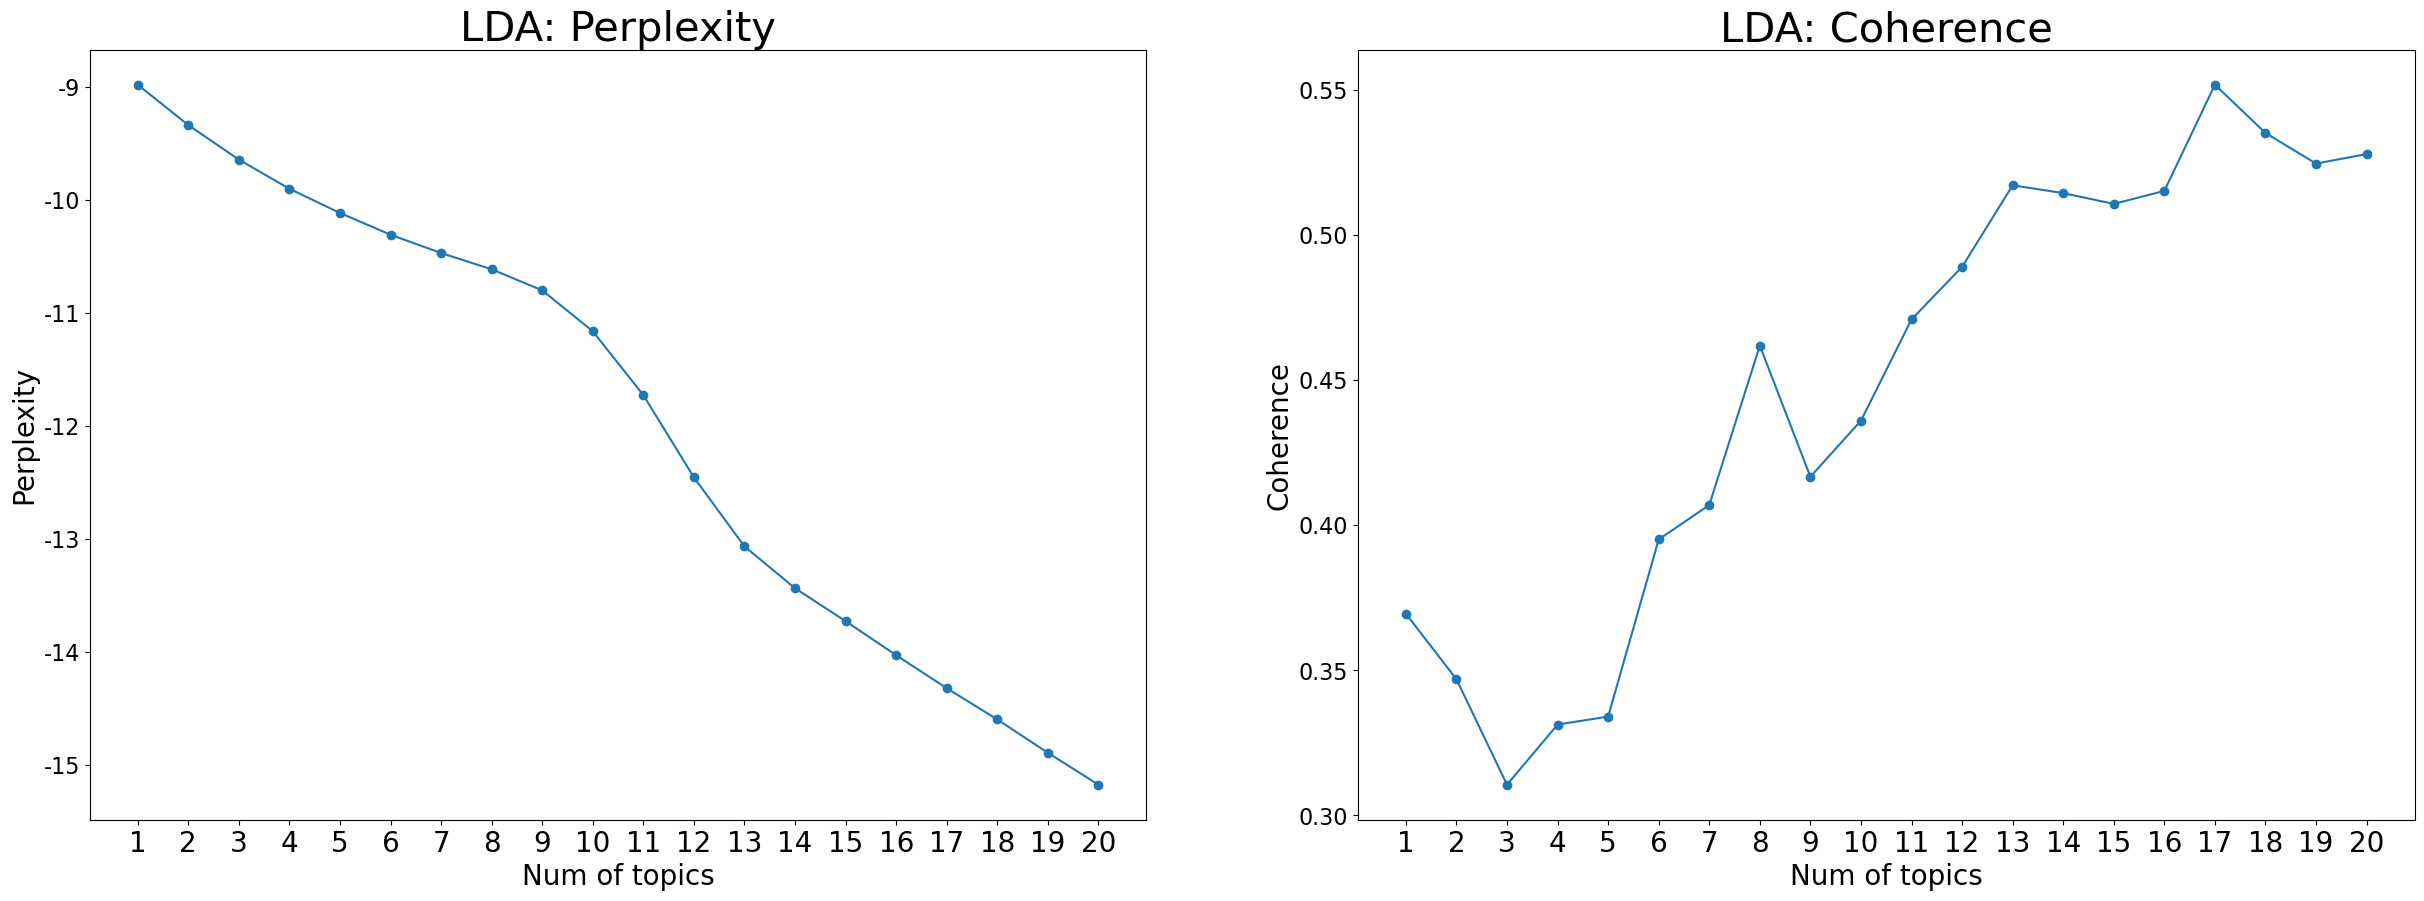

In [46]:
# Determine the number of topics
num_topics = 20
dictionary = Dictionary(texts_tokenized)
# dictionary.filter_n_most_frequent(200)
corpus = [dictionary.doc2bow(text) for text in texts_tokenized] 
corpus_tfidf = TfidfModel(corpus)[corpus]

model_list, x, perplexity_values, coherence_values = lda_model_values(num_topics=num_topics, corpus=corpus_tfidf, dictionary=dictionary) 

# Plot the change of perplexity and coherence
plt.rcParams['axes.unicode_minus'] = False 
fig = plt.figure(figsize=(30,10))

ax1 = fig.add_subplot(1, 2, 1)
plt.plot(x, perplexity_values, marker="o")
plt.title("LDA: Perplexity",fontsize=30)
plt.xlabel('Num of topics',fontsize=20)
plt.ylabel('Perplexity',fontsize=20)
plt.xticks(np.linspace(1, num_topics, num_topics, endpoint=True), size=20)
plt.yticks(size=16)

ax2 = fig.add_subplot(1, 2, 2)
plt.plot(x, coherence_values, marker="o")
plt.title("LDA: Coherence",fontsize=30)
plt.xlabel("Num of topics",fontsize=20)
plt.ylabel("Coherence",fontsize=20)
plt.xticks(np.linspace(1, num_topics, num_topics, endpoint=True), size=20)
plt.yticks(size=16)

plt.show()

In [47]:
lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=17, passes=30, random_state=1)
topic_list=lda.print_topics()

for topic in topic_list:
    print(topic)

(0, '0.031*"«" + 0.030*"»" + 0.021*"homme" + 0.011*"pouvoir" + 0.009*"fille" + 0.009*"côté" + 0.009*"faire" + 0.009*"doute" + 0.008*"luire" + 0.008*"vie"')
(1, '0.025*"partir" + 0.024*"pouvoir" + 0.018*"dernier" + 0.016*"utiliser" + 0.014*"aujourdhui" + 0.013*"vouloir" + 0.012*"revenir" + 0.011*"robot" + 0.011*"bon" + 0.010*"compte"')
(2, '0.026*"beaucoup" + 0.014*"permettre" + 0.012*"argent" + 0.011*"luire" + 0.010*"bien" + 0.010*"esprit" + 0.009*"cause" + 0.009*"mieux" + 0.008*"situation" + 0.008*"préparer"')
(3, '0.081*"faire" + 0.024*"pouvoir" + 0.024*"luire" + 0.017*"rien" + 0.014*"falloir" + 0.012*"tour" + 0.012*"devoir" + 0.011*"main" + 0.011*"temps" + 0.011*"paris"')
(4, '0.017*"voiture" + 0.015*"sou" + 0.015*"prendre" + 0.012*"contre" + 0.011*"blanc" + 0.010*"animal" + 0.010*"amour" + 0.009*"samedi" + 0.009*"histoire" + 0.009*"situer"')
(5, '0.054*"devoir" + 0.029*"pays" + 0.022*"pourcent" + 0.015*"monsieur" + 0.015*"pouvoir" + 0.011*"finir" + 0.009*"soeur" + 0.009*"faire" + 0

In [48]:
texts_tokenized_test = [spacy_tokenizer(text) for text in test['sentence']]

In [49]:
topic_list = []

for i in range(len(texts_tokenized_test)):
    bow_test = dictionary.doc2bow(texts_tokenized_test[i])
    topic = lda.get_document_topics(bow_test)
    topic_list.append(topic)

In [52]:
# Identify the topic for each text with the highest probability
max_topic_list = []

for item in topic_list:
    max_topic_tuple = max(item, key=lambda x: x[1])
    result = max_topic_tuple[0]
    max_topic_list.append(result)

In [54]:
test_topic = test.copy(deep=True)
test_topic['topic'] = pd.Series(max_topic_list)
test_topic

,sentence,topic
0,Nous dûmes nous excuser des propos que nous eû...,12
1,Vous ne pouvez pas savoir le plaisir que j'ai ...,3
2,"Et, paradoxalement, boire froid n'est pas la b...",6
3,"Ce n'est pas étonnant, car c'est une saison my...",6
4,"Le corps de Golo lui-même, d'une essence aussi...",5
...,...,...
1195,C'est un phénomène qui trouve une accélération...,14
1196,Je vais parler au serveur et voir si on peut d...,11
1197,Il n'était pas comme tant de gens qui par pare...,13
1198,Ils deviennent dangereux pour notre économie.,10


## Create Network

In [51]:
# Create tokenizer function and keep only noun
def spacy_tokenizer_noun(text):

    # Define stopwords, punctuation, and numbers
    stop_words = spacy.lang.fr.stop_words.STOP_WORDS
    punctuations = string.punctuation +'–' + '—'
    numbers = "0123456789"

    # Create spacy object
    mytokens = sp(text)

    # Lemmatize each token and convert each token into lowercase
    mytokens = ([ word.lemma_.lower().strip() for word in mytokens if (word.is_stop == False) and (word.is_punct == False) and (word.is_space == False) and (word.pos_ in ['NOUN', 'PROPN'])])

    # Remove sufix like ".[1" in "experience.[1"
    mytokens_2 = []
    for word in mytokens:
        for char in word:
            if (char in punctuations) or (char in numbers):
                word = word.replace(char, "")
        if word != "":
            mytokens_2.append(word)
    
    # Return preprocessed list of tokens
    return mytokens_2

In [52]:
texts_tokenized_test_noun = [spacy_tokenizer_noun(text) for text in test['sentence']]

In [53]:
word_list = [word for text in texts_tokenized_test_noun for word in text]

def count_high_frequency_words(word_list, top_n):
    word_counts = defaultdict(int)

    # Compute word frequency
    for word in word_list:
        word_counts[word] += 1

    # Sort by frequency
    sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

    # Get high-frequency words
    high_frequency_words = [word for word, count in sorted_words[:top_n]]

    return high_frequency_words

In [54]:
topwords = count_high_frequency_words(word_list, 50)

In [55]:
def get_comatrix(text_lines_seg, topwords):
    comatrix = pd.DataFrame(np.zeros([len(topwords),len(topwords)]),columns=topwords,index=topwords)
    for t_seg in text_lines_seg:
        for i in range(len(t_seg)-1):
                for j in range(i+1,len(t_seg)):
                    comatrix.loc[t_seg[i],t_seg[j]]+=1
                    comatrix.loc[t_seg[j],t_seg[i]]+=1
    for k in range(len(comatrix)):
        comatrix.iloc[k,k]=0
    return comatrix

In [56]:
def get_net(co_matrix,topwords):
    g = nx.Graph()
    for i in range(len(topwords)-1):
        word = topwords[i]
        for j in range(i+1,len(topwords)):
            w=0
            word2 = topwords[j]
            w = co_matrix.loc[word][word2]
            if w>0:
                g.add_edge(word,word2,weight=w)
    return g

In [57]:
texts_tokenized_test_topwords = []

for item in texts_tokenized_test_noun:
    text = []
    for word in item:
        if word in topwords:
            text.append(word)
    texts_tokenized_test_topwords.append(text)
    

In [58]:
co_matrix = get_comatrix(texts_tokenized_test_topwords, topwords)
co_net = get_net(co_matrix,topwords)
co_matrix.head(10)

,jour,an,enfant,temps,heure,femme,fois,homme,monde,soir,...,transport,journée,place,donnée,main,esprit,vacance,exemple,monsieur,chien
jour,0.0,1.0,1.0,3.0,3.0,2.0,0.0,1.0,0.0,4.0,...,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,2.0,0.0
an,1.0,0.0,4.0,0.0,0.0,2.0,1.0,2.0,2.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
enfant,1.0,4.0,0.0,0.0,4.0,3.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
temps,3.0,0.0,0.0,0.0,1.0,0.0,2.0,2.0,0.0,0.0,...,0.0,1.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0
heure,3.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,...,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
femme,2.0,2.0,3.0,0.0,0.0,0.0,1.0,7.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
fois,0.0,1.0,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
homme,1.0,2.0,1.0,2.0,0.0,7.0,1.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
monde,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
soir,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [59]:
nx.write_gexf(co_net, 'french.gexf')

# Use gephi for network display

After we acquire the .gexf file, we import it into Gephi for further processing. <a href="Image/Network.jpeg" download>Network.jpeg</a> is the social network of the top 50 high-frequency words we got from Gephi.

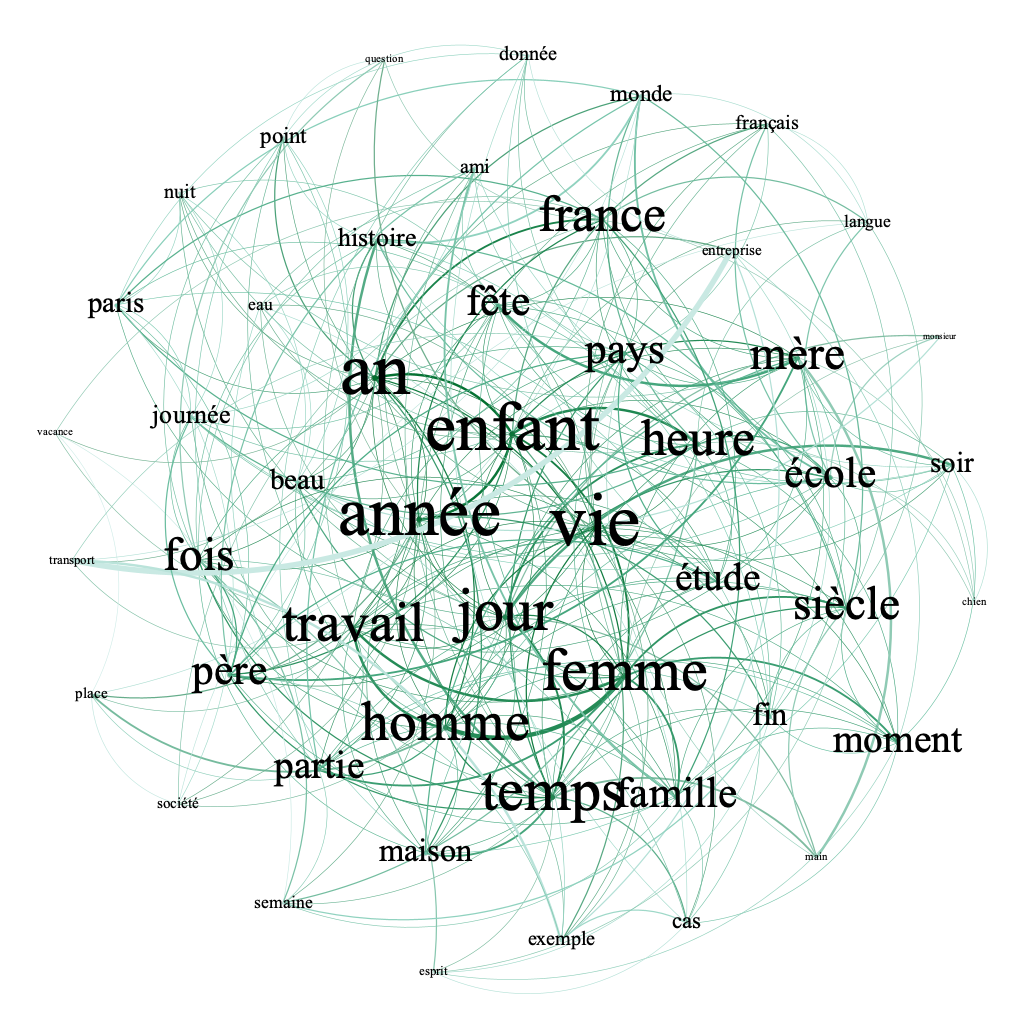

In [ ]:
Image('Image/Network.jpeg')

# PART 3: Youtube Video Matching and Recommendation

## Extract Data through API

In [61]:
SCOPES = ["https://www.googleapis.com/auth/youtube.force-ssl"]

In [62]:
def youtube_authenticate():
    os.environ["OAUTHLIB_INSECURE_TRANSPORT"] = "1"
    api_service_name = "youtube"
    api_version = "v3"
    client_secrets_file = "credentials.json"
    creds = None
    # the file token.pickle stores the user's access and refresh tokens, and is
    # created automatically when the authorization flow completes for the first time
    if os.path.exists("token.pickle"):
        with open("token.pickle", "rb") as token:
            creds = pickle.load(token)
    # if there are no (valid) credentials availablle, let the user log in.
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(client_secrets_file, SCOPES)
            creds = flow.run_local_server(port=0)
        # save the credentials for the next run
        with open("token.pickle", "wb") as token:
            pickle.dump(creds, token)

    return build(api_service_name, api_version, credentials=creds)

In [63]:
def get_video_details(youtube, **kwargs):
    return youtube.videos().list(
        part="snippet,contentDetails,statistics",
        **kwargs
    ).execute()

In [64]:
def get_video_infos(video_response):
    items = video_response.get("items")[0]
    # get the snippet, statistics & content details from the video response
    snippet = items["snippet"]
    statistics = items["statistics"]
    content_details = items["contentDetails"]
    # get infos from the snippet
    channel_title = snippet["channelTitle"]
    title = snippet["title"]
    description = snippet["description"]
    thumbnails_url = snippet['thumbnails']['default']['url']
    return title, description, thumbnails_url

In [65]:
def search(youtube, **kwargs):
    return youtube.search().list(
        part="snippet",
        type="video",
        **kwargs
    ).execute()

In [66]:
def retrieve_video_list(keyword):
    # authenticate to YouTube API
    youtube = youtube_authenticate()
    
    # search for the query 'python' and retrieve results items only
    response = search(youtube, q=keyword, maxResults=50, relevanceLanguage="FR", videoCaption="closedCaption")
    items = response.get("items")
    df_video = pd.DataFrame(columns=['video url', 'title', 'description', 'thumbnails url', 'caption', 'difficulty'])
    for item in tqdm.tqdm(items):
        # get the video ID
        video_id = item["id"]["videoId"]
        # get the video details
        video_response = get_video_details(youtube, id=video_id)
        title, description, thumbnails_url = get_video_infos(video_response)

        # assigning srt variable with the list
        # of dictionaries obtained by the get_transcript() function
        try:
            srt = YouTubeTranscriptApi.get_transcript(video_id, languages=['fr'])
            caption = '. ' .join(item['text'] for item in srt)
            caption = caption.replace('\n', ' ')
            video = {'video url': 'https://www.youtube.com/watch?v=' + video_id, 'title': title, 'description': description, 'thumbnails url': thumbnails_url, 'caption':caption}
            df_video = df_video.append(video, ignore_index=True)
        
        except:
            continue
    
    return df_video

## Predict and Recommend with Interactive Widgets

In [67]:
def predictor(keyword, level):
    # Retrieve the videos using keyword
    df_video = retrieve_video_list(keyword)

    # Extract text features through bert
    test_features = bert_feature(df_video['caption'], max_length=256)

    # Predict difficulty
    pred_difficulty = etc_model_best.predict(test_features)
    df_video['difficulty'] = pd.Series(pred_difficulty).map({0:'A1', 1:'A2', 2:'B1', 3:'B2', 4:'C1', 5:'C2'})

    # Match the difficulty with input
    df_result = df_video[df_video['difficulty'] == level].reset_index()

    return df_result

In [68]:
import ipywidgets as widgets
from IPython.display import display, HTML, Image

# Create Input and Selector
keyword_input = widgets.Text(description='Keyword: ')
keyword_input.layout.width = '20%'

level_dropdown = widgets.Dropdown(options=['A1', 'A2', 'B1', 'B2', 'C1', 'C2'], description='Level: ')
level_dropdown.layout.width = '20%'

# Create button
show_videos_button = widgets.Button(description='Display Recommended Youtube Videos')
show_videos_button.layout.margin = '10px 0 0 5%'
show_videos_button.layout.width = '25%'
show_videos_button.button_style = 'success'

loading_icon = HTML('<i class="fa fa-spinner fa-pulse fa-3x fa-fw"></i><span class="sr-only">加载中...</span>')

# Create an output block
videos_output = widgets.Output()

# Define the function for button click event
def show_videos(show_videos_button):
    with videos_output:
        videos_output.clear_output()

        # Get the value of keyword and level
        keyword = keyword_input.value
        level = level_dropdown.value

        # Disable the button
        show_videos_button.disabled = True

        # Display the loading icon
        display(loading_icon)
        
        # Execute the predictor function
        df_result = predictor(keyword, level)

        videos_output.clear_output()

        if len(df_result) != 0:
            if len(df_result) == 1:
                print('There is 1 video recommended for you!')
            else:
                print('There are {} videos recommended for you!'.format(len(df_result)))
            
            print('='*50)
            for i in range(len(df_result)):
                print(str(i+1)+'. Title: ', df_result['title'][i])
                print('\nurl: ', df_result['video url'][i])
                display(Image(df_result['thumbnails url'][i]))
                print('='*50)
        else:
            print('There is no match for your input! Please change your keyword or level! (Note: Most videos are above C1 level)')
        
        show_videos_button.disabled = False

# Connect the click event and the function
show_videos_button.on_click(show_videos)

# Create overall layout
layout = widgets.VBox([keyword_input, level_dropdown, show_videos_button])

display(layout)
display(videos_output)

Output()

Turn to <a href='streamlit.py'>streamlit.py</a> to run the interface on web.